In [9]:
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os
import requests
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
import hvplot.pandas
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#Import SKLearn Library and Classes
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [10]:
#set path to Features CSV and read in CSV
tsla_df = pd.read_csv('TSLA_results.csv')
tsla_df.head()
tsla_df = tsla_df.rename(columns={'Unnamed: 0': 'DataDate'})
tsla_df = tsla_df.set_index(pd.to_datetime(tsla_df.DataDate, infer_datetime_format=True))
tsla_df=tsla_df.drop(tsla_df.columns[0], axis=1)

tsla_df


,Call Volume,Put Volume,Total Volume,Percent of cPut,Put signals,Percent of calls,Call signals,Option rVol,option rvol delta,Close,...,bollinger_signal,rvol,rvol SD,rvol signal,daily returns,volume delta,bb std delta,rvol delta,Option rVol SD,Option rVol signal
DataDate,,,,,,,,,,,,,,,,,,,,,
2016-02-26,61082.0,55707.0,116789.0,0.476988,False,0.523012,False,1.265347,0.009447,38.068001,...,0.0,0.918543,1.476481,0.0,0.015526,0.000000,0.000000,0.000000,NaN,0.0
2016-02-29,38760.0,33531.0,72291.0,0.463834,False,0.536166,False,0.765316,-0.395173,38.386002,...,0.0,0.672970,1.475945,0.0,0.008353,-0.258215,-0.612534,-0.267351,NaN,0.0
2016-03-01,46761.0,66906.0,113667.0,0.588614,False,0.411386,False,1.126356,0.471753,37.270000,...,1.0,0.993514,1.464062,0.0,-0.029073,0.491932,0.259721,0.476312,0.945510,0.0
2016-03-02,36792.0,43244.0,80036.0,0.540307,False,0.459693,False,0.902682,-0.198582,37.667999,...,0.0,0.724600,1.435430,0.0,0.010679,-0.275588,-0.016266,-0.270669,0.883082,0.0
2016-03-03,51158.0,52002.0,103160.0,0.504091,False,0.495909,False,1.042501,0.154893,39.147999,...,-1.0,0.736651,1.375740,0.0,0.039291,-0.006869,0.749635,0.016632,0.894204,0.0
2016-03-04,77654.0,76083.0,153737.0,0.494891,False,0.505109,False,1.368851,0.313045,40.208000,...,0.0,0.974263,1.375180,0.0,0.027077,0.343777,0.289201,0.322556,0.882234,0.0
2016-03-07,53174.0,46225.0,99399.0,0.465045,False,0.534955,False,0.836936,-0.388585,41.057999,...,0.0,0.825609,1.296997,0.0,0.021140,-0.178715,-0.249929,-0.152581,0.905532,0.0
2016-03-08,34981.0,53040.0,88021.0,0.602583,True,0.397417,False,0.774022,-0.075172,40.520000,...,0.0,0.674158,1.222082,0.0,-0.013103,-0.215915,-0.550666,-0.183442,0.899704,0.0
2016-03-09,38633.0,40877.0,79510.0,0.514111,False,0.485889,False,0.893605,0.154496,41.743999,...,-1.0,0.541422,1.158467,0.0,0.030207,-0.232154,0.426794,-0.196892,0.751494,0.0


In [11]:
#Create new trading signals Df, 
trading_signals_df = pd.DataFrame()

In [12]:
#create features only dataframe by shifting feature signal, select features as x_var_list (for selling OTM puts, bollinger = bollinger short)

x_var_list = ['bollinger_short', 'rvol signal', 'Option rVol signal']

trading_signals_df[x_var_list] = tsla_df[x_var_list].shift(1)

trading_signals_df = trading_signals_df.set_index(pd.to_datetime(tsla_df.index, infer_datetime_format=True))
#trading_signals_df['b']

In [13]:
#add dependent variable for targeting a positive return, shift forward looking window by user defined amount
shift = 7
threshold = 0
trading_signals_df['Positive Return'] = np.where(tsla_df['daily returns'].shift(-shift)> threshold, 1, 0)

In [14]:
#drop Na and reduce df by shift amount
trading_signals_df = trading_signals_df.dropna()
trading_signals_df = trading_signals_df[:-shift]
trading_signals_df.tail()

,bollinger_short,rvol signal,Option rVol signal,Positive Return
DataDate,,,,
2020-01-14,-1.0,1.0,1.0,0
2020-01-15,0.0,1.0,1.0,0
2020-01-16,0.0,0.0,0.0,1
2020-01-17,0.0,0.0,0.0,1
2020-01-21,0.0,0.0,0.0,1


In [15]:
# Manually splitting the data
split = int(0.7 * len(trading_signals_df))

X_train = trading_signals_df.iloc[: split, :-1]
X_test = trading_signals_df.iloc[split:, :-1]

y_train = trading_signals_df['Positive Return'][:split]
y_test = trading_signals_df['Positive Return'][split:]
trading_signals_df.tail()

,bollinger_short,rvol signal,Option rVol signal,Positive Return
DataDate,,,,
2020-01-14,-1.0,1.0,1.0,0
2020-01-15,0.0,1.0,1.0,0
2020-01-16,0.0,0.0,0.0,1
2020-01-17,0.0,0.0,0.0,1
2020-01-21,0.0,0.0,0.0,1


In [23]:
#Train Random Forest Model
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

In [25]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["RF Predicted Value"] = predictions
Results['Forward Daily Returns'] = tsla_df['daily returns'].shift(-shift)
Results

,Positive Return,RF Predicted Value,Forward Daily Returns
2019-11-12,0,1,-0.035863
2019-11-13,0,1,-0.009131
2019-11-14,1,1,0.016863
2019-11-15,0,1,-0.020854
2019-11-18,1,1,0.011291
2019-11-19,0,1,-0.006851
2019-11-20,0,1,-0.010475
2019-11-21,1,1,0.003958
2019-11-22,1,1,0.020747
2019-11-25,0,0,-0.001764


In [26]:
Results['RF Predicted Value'].to_pickle(r'C:\Users\Kiel\Desktop\FINTECH\UCB_fintech_homework\project_2 - local\Resources\RF_signals_df.pickle')

<AxesSubplot:>

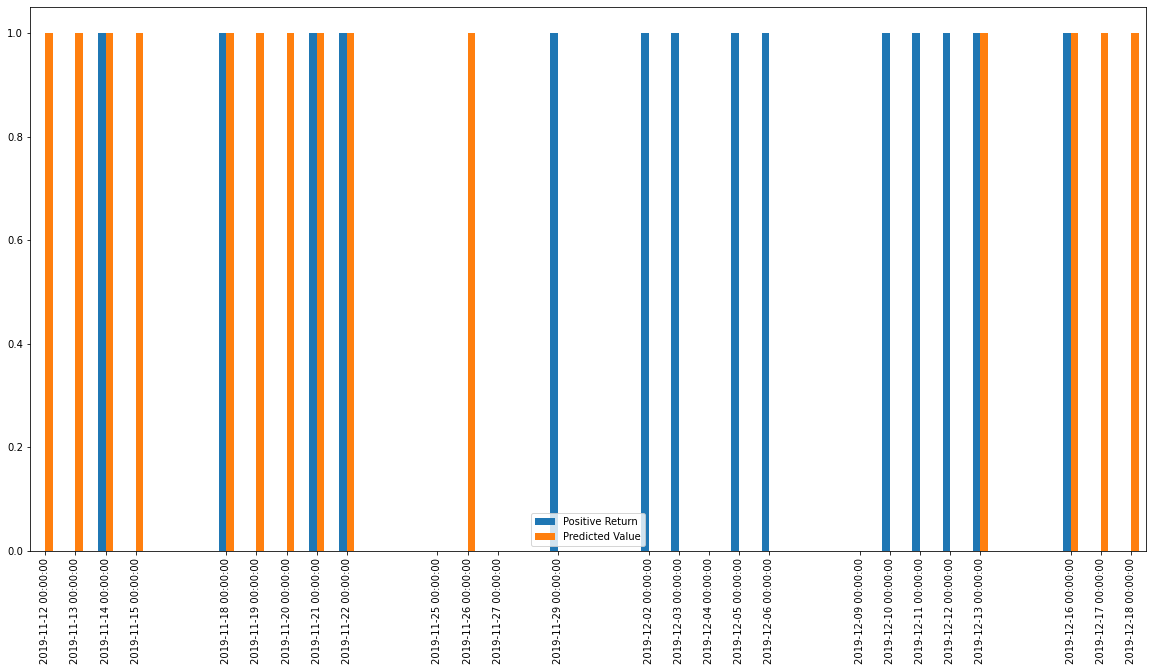

In [12]:
Results[['Positive Return', 'Predicted Value']].plot(figsize=(20,10), kind = 'bar')

In [13]:
Results['Positive Return'].sum()

14

<AxesSubplot:>

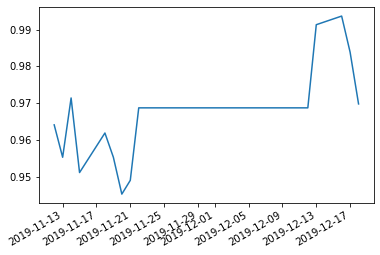

In [14]:
# Calculate cumulative return of model and plot the result
(1 + (Results['Forward Daily Returns'] * Results['Predicted Value'])).cumprod().plot()

<AxesSubplot:>

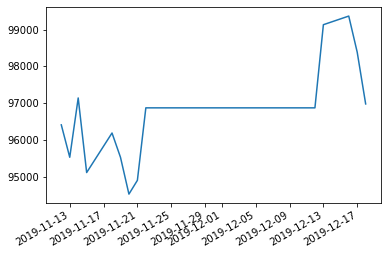

In [15]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (Results['Forward Daily Returns'] * Results['Predicted Value'])).cumprod()
cumulative_return_capital.plot()